# 4. PyTorch Custom Datasets

We can use our own data into PyTorch using -> Custom Datasets

Depending on what we are working on, vision, text, audio, recommendataion, you'll want to look into each of the PyTorch domain libraries for existing dta loading functions and suctomizable data loading functions

## **0.** Importing Libraries and setting up device-agnostic code

In [1]:
import torch
import torchvision
from torch import nn

#Device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'



## **1.** Get Datasets

Dataset which will be used is a subset of the Food101 dataset.

Food101 has 101 classes of food, with 1000 images of each (750 train, 250 test)

Our data has 3 classes of food, with 100 images of each (75 train, 25 test).

Why do this?
* Important to start out small, then incease scale
* Speeds up the experimentation

In [2]:
import requests
import zipfile
from pathlib import Path

# Setup path to a data folder
data_path = Path('data/')
image_path = data_path/ "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
  print(f"Directory exists, skipping download")
else:
  print(f"Creating new directory")
  image_path.mkdir(parents=True, exist_ok=True)

Creating new directory


In [3]:
# Download pizza, steak and sushi data
with open(data_path / 'pizza_steak_sushi.zip' , 'wb') as f:
  request = requests.get('https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip')
  print('Downloading pizza, steak, sushi data...')
  f.write(request.content)

# Unzip the data
with zipfile.ZipFile(data_path / 'pizza_steak_sushi.zip' , 'r') as zip_ref:
  print('Unzipping pizza, steak and sushi data...')
  zip_ref.extractall(image_path)

Unzipping pizza, steak and sushi data...


## **2.** Data Exploration and preparation

In [4]:
import os
def walk_through_dir(dir_path):
  """
  Walks through the path returning its contents.
  """
  for dirpath, dirnames, filnames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filnames)} images in `{dirpath}`.")

walk_through_dir(image_path)

There are 2 directories and 0 images in `data/pizza_steak_sushi`.
There are 3 directories and 0 images in `data/pizza_steak_sushi/train`.
There are 0 directories and 75 images in `data/pizza_steak_sushi/train/steak`.
There are 0 directories and 72 images in `data/pizza_steak_sushi/train/sushi`.
There are 0 directories and 78 images in `data/pizza_steak_sushi/train/pizza`.
There are 3 directories and 0 images in `data/pizza_steak_sushi/test`.
There are 0 directories and 19 images in `data/pizza_steak_sushi/test/steak`.
There are 0 directories and 31 images in `data/pizza_steak_sushi/test/sushi`.
There are 0 directories and 25 images in `data/pizza_steak_sushi/test/pizza`.


In [5]:
# Setup train and testing paths
train_dir = image_path / 'train'
test_dir = image_path / 'test'

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

### 2.1 Visualizing and image

Let us write code to:
1. Get all the image paths
2. Pick random image path using random.choice()
3. Get the image class name using `pathling.Path.parent.stem`
4. Open image with PIL
5. We'ss will show and print meta data

In [6]:
image_path

PosixPath('data/pizza_steak_sushi')

Random image path: data/pizza_steak_sushi/train/steak/355715.jpg
Image class: steak
Image height: 382
image width: 512


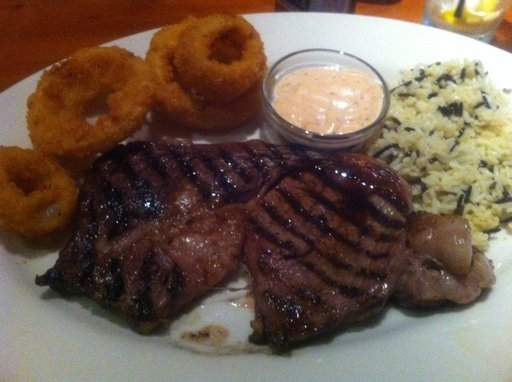

In [7]:
import random
from PIL import Image

#set seed
random.seed(42)

# 1. Get all image paths
image_path_list = list(image_path.glob('*/*/*.jpg'))
# first * : test or train
# second * : pizza / sushi / steak
# third * : Any image within the folder

# 2. Pick a random image path
random_image_path = random.choice(image_path_list)

# 3. Get image class [food name] where image is saved
image_class = random_image_path.parent.stem

# 4. Open iamge
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"image width: {img.width}")

img

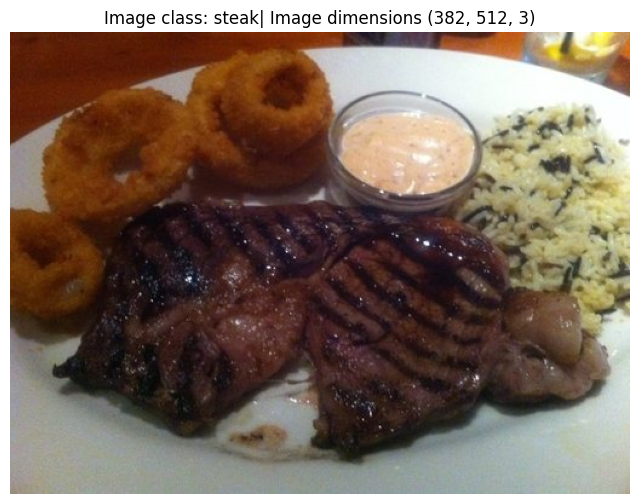

In [8]:
# Try to Use numpy
import numpy as np
import matplotlib.pyplot as plt

# Turn image into a array
img_as_array = np.asarray(img) # PIL Image to matplotlib image -> need to convert to numpy

# Plot the image
plt.figure(figsize=(12,6))
plt.title(f"Image class: {image_class}| Image dimensions {img_as_array.shape}") # height, weight, colors
plt.axis(False)
plt.imshow(img_as_array)

## **3.** Transforming data

Transform data into tensor format to be useable for PyTorch:
1. Turn your target data into tensors (in our case, numerical representation of our images).
2. Change `torch.utils.Datasets` -> `torch.utils.DataLoaders`: From pytorch dataset to python iterables

In [9]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

### 3.1 Transforming data with `torchvision.transforms`

Transforms het the images ready to be used with the model

In [10]:
from typing_extensions import dataclass_transform
# Write a transform for image
data_transform = transforms.Compose([
    # Resize images to 64x64
    transforms.Resize(size=(64,64)),
    # We perform this so that we can use pre-build models which have same config. Ex: TinyVGG

    # Flip the images randomly -> (AKA) Data Augmentation, which increases the diversity of the dataset
    transforms.RandomHorizontalFlip(0.5),
    # 50% of the images which get transformed will be flipped horizontally

    # Turn the image into a tensor
    transforms.ToTensor()
])
# nn.Sequential can also be used instead of transforms.Compose to have a sequence of transformations

In [11]:
data_transform(img).shape, data_transform(img).dtype
# Colors, height, width

(torch.Size([3, 64, 64]), torch.float32)

In [12]:
def plot_transformed_images(image_paths : list,
                            transform,
                            n=3,
                            seed=None):
  """
  Selects 3 random images when passed in the list of paths
  Print the transformed version vs. the original version.
  """
  if seed:
    random.seed(seed)
  random_image_paths = random.sample(image_paths, k=n)

  for random_image_path in random_image_paths:
    with Image.open(random_image_path) as f:
      fig , ax = plt.subplots(nrows=1, ncols=2) # fig is the 2 picture spaces togather
      # ax - one space within the figure.
      # Many ax makes up one figure
      ax[0].imshow(f)
      ax[0].set_title(f"Original\nSize: {f.size}")
      ax[0].axis(False)

      # Transform and plot target image
      transformed_image = transform(f).permute(1, 2, 0) # Dimension change
      # As PIL has h,w,c but tensor will have c,h,w
      ax[1].imshow(transformed_image)
      ax[1].set_title(f"Transformed\nSize: {transformed_image.shape}")
      ax[1].axis(False)

      fig.suptitle(f"Class: {random_image_path.parent.stem}", fontsize=16)

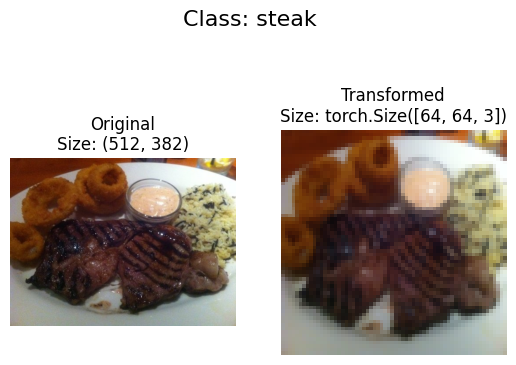

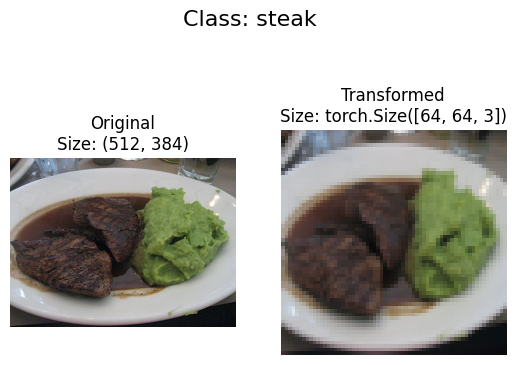

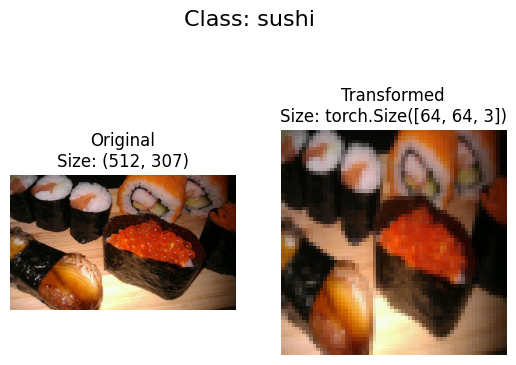

In [13]:
plot_transformed_images(image_path_list, transform=data_transform, n = 3, seed=42)

## **4.** Option 1: Loading iamge data using `ImageFolder`

Load image classification data using `torchvision.dataset.ImageFolder-`

In [14]:
# Use ImageFoler to create dataset(s) : which we usually import from torch.datasets
from torchvision import datasets
train_data = datasets.ImageFolder(root=train_dir,
                                  transform=data_transform,
                                  target_transform=None # No need for transforming labels as they are in std image classification format
                                  # image classification format: test, train folder -> different classes -> respective images
                                  # So if not using std one, we will not use ImageFolder
                                  )

test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform,
                                 )

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [15]:
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [16]:
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [17]:
train_data.samples[0]

('data/pizza_steak_sushi/train/pizza/1008844.jpg', 0)

In [18]:
# index on the train_data Dataset and get single image and label
image, label = train_data[0][0], train_data[0][1]

In [19]:
print(f'Image tensor: {image}')
print(f'Image shape: {image.shape}')
print(f'Image data type: {image.dtype}')
print(f'Image label: {label}')
print(f'label data type: {type(label)}')

Image tensor: tensor([[[0.1176, 0.1216, 0.1255,  ..., 0.0980, 0.1020, 0.1137],
         [0.1294, 0.1294, 0.1294,  ..., 0.0980, 0.0980, 0.1059],
         [0.1333, 0.1333, 0.1333,  ..., 0.0941, 0.0980, 0.1020],
         ...,
         [0.1686, 0.1647, 0.1686,  ..., 0.1255, 0.1098, 0.1098],
         [0.1686, 0.1647, 0.1686,  ..., 0.1098, 0.0941, 0.0902],
         [0.1647, 0.1647, 0.1686,  ..., 0.0980, 0.0863, 0.0863]],

        [[0.0588, 0.0588, 0.0588,  ..., 0.0745, 0.0706, 0.0745],
         [0.0627, 0.0627, 0.0627,  ..., 0.0745, 0.0706, 0.0745],
         [0.0706, 0.0706, 0.0706,  ..., 0.0745, 0.0745, 0.0706],
         ...,
         [0.2392, 0.2392, 0.2510,  ..., 0.1373, 0.1333, 0.1255],
         [0.2314, 0.2392, 0.2510,  ..., 0.1255, 0.1176, 0.1098],
         [0.2275, 0.2353, 0.2431,  ..., 0.1137, 0.1059, 0.1020]],

        [[0.0196, 0.0196, 0.0157,  ..., 0.0902, 0.0902, 0.0941],
         [0.0196, 0.0157, 0.0196,  ..., 0.0902, 0.0863, 0.0902],
         [0.0196, 0.0157, 0.0157,  ..., 0.09

Original Shape: torch.Size([3, 64, 64])| Permuted shape: tensor([[[0.1176, 0.0588, 0.0196],
         [0.1216, 0.0588, 0.0196],
         [0.1255, 0.0588, 0.0157],
         ...,
         [0.0980, 0.0745, 0.0902],
         [0.1020, 0.0706, 0.0902],
         [0.1137, 0.0745, 0.0941]],

        [[0.1294, 0.0627, 0.0196],
         [0.1294, 0.0627, 0.0157],
         [0.1294, 0.0627, 0.0196],
         ...,
         [0.0980, 0.0745, 0.0902],
         [0.0980, 0.0706, 0.0863],
         [0.1059, 0.0745, 0.0902]],

        [[0.1333, 0.0706, 0.0196],
         [0.1333, 0.0706, 0.0157],
         [0.1333, 0.0706, 0.0157],
         ...,
         [0.0941, 0.0745, 0.0902],
         [0.0980, 0.0745, 0.0902],
         [0.1020, 0.0706, 0.0902]],

        ...,

        [[0.1686, 0.2392, 0.1843],
         [0.1647, 0.2392, 0.1882],
         [0.1686, 0.2510, 0.1961],
         ...,
         [0.1255, 0.1373, 0.1490],
         [0.1098, 0.1333, 0.1333],
         [0.1098, 0.1255, 0.1294]],

        [[0.1686, 0.2314,

Text(0.5, 1.0, 'pizza')

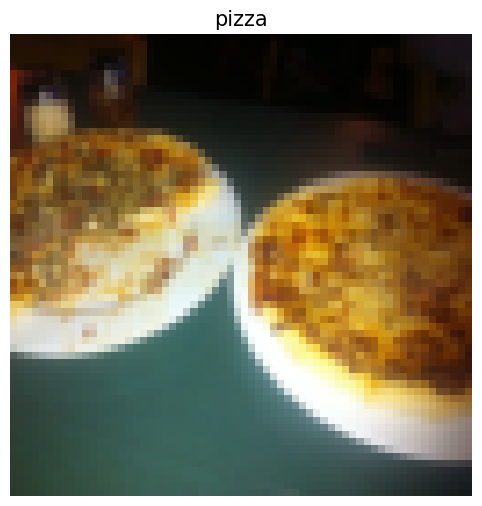

In [20]:
# Rearrange order of dimersions
img_permute = image.permute(1,2,0)

# Print out different shapes
print(f'Original Shape: {image.shape}| Permuted shape: {img_permute}')
print(f'color, height, width   -->  height, width, color')

# Plot the image
plt.figure(figsize=(10, 6))
plt.imshow(img_permute)
plt.axis(False)
plt.title(class_names[label], fontsize=15)

### 4.1 Turn loaded images into `DataLoader`'s

Turns dataset into python iterable

Can chunck it up into batches to help with hardware constraints

In [21]:
BATCH_SIZE = 1
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              num_workers=os.cpu_count(),
                              shuffle=True,
                              )

test_dataloader = DataLoader(dataset=test_data,
                              batch_size=BATCH_SIZE,
                              shuffle=False,
                              num_workers=os.cpu_count(), # No. of CPUs used to load the dataset as dataloaders
                              # The higher the better
                              )

img, target = next(iter(train_dataloader))

img, target

(tensor([[[[0.5686, 0.5451, 0.4902,  ..., 0.5725, 0.5843, 0.5804],
           [0.5529, 0.5294, 0.5098,  ..., 0.5725, 0.5882, 0.6039],
           [0.5529, 0.5020, 0.5294,  ..., 0.5137, 0.5569, 0.6000],
           ...,
           [0.5216, 0.5098, 0.5216,  ..., 0.3961, 0.3961, 0.4039],
           [0.5333, 0.5216, 0.5255,  ..., 0.4000, 0.4078, 0.4118],
           [0.5255, 0.5137, 0.5176,  ..., 0.4000, 0.4118, 0.4196]],
 
          [[0.4863, 0.4706, 0.4353,  ..., 0.4431, 0.4824, 0.4824],
           [0.4902, 0.4745, 0.4510,  ..., 0.3961, 0.4157, 0.4588],
           [0.4824, 0.4549, 0.4706,  ..., 0.3137, 0.3569, 0.4314],
           ...,
           [0.6235, 0.6275, 0.6353,  ..., 0.2000, 0.2000, 0.2039],
           [0.6353, 0.6235, 0.6196,  ..., 0.2039, 0.2039, 0.2078],
           [0.6157, 0.6196, 0.6235,  ..., 0.2000, 0.2000, 0.2039]],
 
          [[0.5608, 0.5529, 0.5255,  ..., 0.4431, 0.5255, 0.5569],
           [0.5529, 0.5529, 0.5373,  ..., 0.3098, 0.3647, 0.4353],
           [0.5490, 0.52

In [22]:
len(train_dataloader), len(test_dataloader)
# The same number as images in train and test data

(225, 75)

In [23]:
print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {target.shape}")

Image shape: torch.Size([1, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([1])


##  **5.** Option 2: Loading Image with a custom `Dataset`

1. Want to be able to load images from file
2. Get class names form Dataset
3. Get classes as dictionary form the Dataset

Pros:
* Create a `Dataset` from almost anything
* Not limited to PyTorch pre-built `Dataset` functions

Cons:
* Even though you could create `Dataset` out of almost anything, it doesn't mean it will work...
* Usin a custon `Dataset` often results in more code from us -> More errors/ Performance issues


***All custom dataset in PyTorch, often subclass from Datasets in torch***

In [24]:
import os
import pathlib
import torch

from torch.utils.data import Dataset
from PIL import Image
from torchvision import transforms
from typing import Tuple, Dict, List

### 5.1 Creating a helper function to get class names

We want a function to:

1. Get the class names using `os.scandir()` to traverse a target directory (ideally the directory is in standard image classification format).
2. Raise an error if the class names aren't found (Directory structure might be wrong if this happens)
3. Turn the class names into a dict and list and return them.

In [25]:
# Setup path directory
target_directory = train_dir
print(f"Target Directory {target_directory}")

# Get the calss names from the target directory
class_names_found = sorted([entry.name for entry in list(os.scandir(target_directory))])
class_names_found

Target Directory data/pizza_steak_sushi/train


['pizza', 'steak', 'sushi']

In [26]:
list(os.scandir(target_directory))

[<DirEntry 'steak'>, <DirEntry 'sushi'>, <DirEntry 'pizza'>]

In [27]:
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
  """
  Finds the class folder names in a target directory.
  """
  # 1. Get the class names by scanning the target directory
  classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())

  # 2. Raise and error if class names could not be found
  if not classes:
    raise FileNotFoundError(f"Couldnt' find any calsses in {directory} .... plese check file structures")

  # 3. Create a dictionary of index labels (computers prefer numbers rather than strings as labels)
  class_to_idx = {class_name : i for i, class_name in enumerate(classes)}

  return classes, class_to_idx

In [28]:
find_classes(target_directory)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.2 Create a custom `Dataset` to replicate `ImageFolder`

To create our own custom dataset,, we want to:

1. Subclass `torch.utils.data.Datset`
2. Init our sublass with a target directory (the directory we'd like to get data from) as well as transform if we'd like to transform our data.
3. Create several attributes:
  * paths - paths of images
  * transform - the transform we'd like to use
  * classes - a list of the target classes
  * class_to_idx - a dict of the target classes mapped to integer labels
4. Create a function to `load_images()`, this fucntion will open an image
5. Overwirte the `__len()__` method to return the length of our dataset
6. Overwrite the `__getitem()__` method to return a given sample when passed and index                                              

In [29]:
# 0. Write a custom dataset class
from torch.utils.data import Dataset

# 1. Subclass torch.utils.data.Dataset
class ImageFolderCustom(Dataset):

  # 2. initialize our custom dataset
  def __init__(self,
               target_directory:str,
               transform=None):

    # 3. Create class attributes
    # Get all of the image paths
    self.paths = list(pathlib.Path(target_directory).glob('*/*.jpg')) # EX: pizza, 2032.jpg
    # Since the starting directory is either test of train, there is only 2 stars

    # Setup transforms
    self.transform = transform

    # Create classes and classes_to_idx
    self.classes, self.class_to_idx = find_classes(target_directory)

  # 4. Create a function to load images
  def load_image(self, index: int) -> Image.Image:
    "Opens an image via a path an returns it"
    image_path = self.paths[index]
    return Image.open(image_path)

  # 5. Overwrite __len()__
  def __len__(self) -> int:
    "returns the total number of sampls"
    return len(self.paths)

  # 6. Overwirte ___getitem()__
  def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
    "Returns one sample of data, data and label (X, y)"
    img = self.load_image(index)
    class_name = self.paths[index].parent.name # expects path in format: data_folder/class_name/image.jpg
    class_idx = self.class_to_idx[class_name]

    # Transform if necessary
    if self.transform:
      return self.transform(img), class_idx # return data, label(X, y)
    return img, class_idx # return untransformed image and label

In [30]:
# Create a transform
trani_transforms = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.RandomHorizontalFlip(0.5),
    transforms.ToTensor()
])

test_transforms = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor(),
])

In [31]:
# Test out ImageFolderCustom
train_data_custom = ImageFolderCustom(target_directory=train_dir,
                                      transform=trani_transforms)

test_data_custom = ImageFolderCustom(target_directory=test_dir,
                                     transform=test_transforms)

train_data_custom, test_data_custom

(<__main__.ImageFolderCustom at 0x7fd2c82699f0>,
 <__main__.ImageFolderCustom at 0x7fd2c8269150>)

In [33]:
len(train_data), len(train_data_custom), len(test_data), len(test_data_custom)

(225, 225, 75, 75)

In [35]:
train_data_custom.classes, train_data_custom.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

In [36]:
# Check if both ImageFolders are equal
print(train_data.classes==train_data_custom.classes)
print(test_data.class_to_idx==test_data_custom.class_to_idx)

True
True


### 5.3 Create a function to display random images

1. Take in a `Dataset` and other parameters such as class anmes and how many images to visualize.
2. To prevent the display, cap @ 10
3. Set the random sed for reproducibility
4. Get a list of random sample indexes from the target dataset.
5. Setup a matplotlib plot.
6. Loop through the random sample images and plot them with matplotlib
7. Make sure the dimensions of our images line up with matplotlib (HWC)

In [50]:
# 1. Create a function to take in a dataset
def display_random_images(
    dataset: torch.utils.data.Dataset,
    classes: List[str] = None,
    n: int = 10,
    display_shape: bool = True,
    seed: int = None
    ):
  # 2. Adjust display if n is too high
  if n > 10:
    n = 10
    display_shape = False
    print(f"N cannot be larger than 10")

  # 3. Set the seed
  if seed:
    random.seed(seed)

  # 4. Get random sample indexes
  random_samples_idx = random.sample(range(len(dataset)), k=10)

  # 5. Setup Plot
  plt.figure(figsize=(16,8))

  # 6. Loop through random indexs and plot them with matplotlib
  for i, targ_sample in enumerate(random_samples_idx):
    targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

    # 7. Adjust tensor dimension for plotting
    targ_image_adjust = targ_image.permute(1, 2, 0) # color_channels, height, width -> height, width, color_channels

    # Plot adjusted samples
    plt.subplot(1, n, i+1)
    plt.imshow(targ_image_adjust)
    plt.axis(False)
    if classes:
      title = f"Class: {classes[targ_label]}"
      if display_shape:
        title = title + f"\nshape: {targ_image_adjust.shape}"
    plt.title(title, fontsize=10)

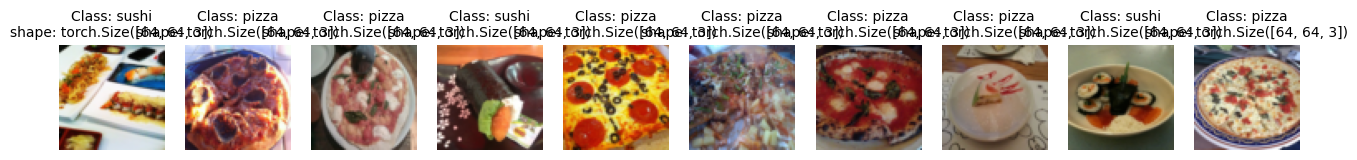

In [57]:
# Display random images from the ImageFolder created Dataset
display_random_images(train_data,
                     n=10,
                     classes=class_names,
                     seed=42)

N cannot be larger than 10


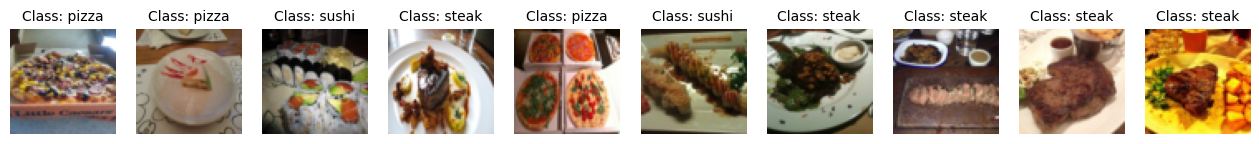

In [55]:
display_random_images(train_data_custom,
                      n=20,
                      classes=class_names,
                      seed=None)